# Chapter 4: Dipping Toes in Deep Learning

## Recurrent Neural Networks

Recurrent neural networks (RNNs) have proven their success in learning from time-series data.

In this chapter, we will use a RNN to learn to predict CO2 concentration levels in the next 5 years. Specifically, you will learn the following.

* How to do simple data exploration on time series data
* How to define a RNN model
* How to transfrom time series data to train a sequential model
* How to train a model

<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/thushv89/manning_tf2_in_action/blob/master/Ch04-Deep-Networks-with-Keras/4.3.Recurrent_networks.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
    </td>
</table>

In [1]:
import random
import os
import pandas as pd
from tensorflow.keras import layers, models
import tensorflow as tf
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

def fix_random_seed(seed):
    """ Setting the random seed of various libraries """
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true"
# Fixing the random seed
fix_random_seed(4321)
print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.19.0


## Reading the data

In [2]:
# Section 4.3

import pandas as pd
import requests
import os

def download_data():
    """ This function downloads the CO2 data from
    https://datahub.io/core/co2-ppm/r/co2-mm-gl.csv
    if the file doesn't already exist
    """
    save_dir = "data"
    save_path = os.path.join(save_dir, 'co2-mm-gl.csv')

    # Create directories if they are not there
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Download the data and save
    if not os.path.exists(save_path):
        url = "https://datahub.io/core/co2-ppm/r/co2-mm-gl.csv"
        r = requests.get(url)
        with open(save_path, 'wb') as f:
            f.write(r.content)
    else:
        print("co2-mm-gl.csv already exists. Not downloading.")
    return save_path

# Downloading the data
save_path = download_data()

# Load the data
data = pd.read_csv(save_path)
data.head()

,,Date,Decimal Date,Average,Trend
1979-01,1979.042,336.56,0.11,335.92,0.10
1979-02,1979.125,337.29,0.09,336.25,0.10
1979-03,1979.208,337.88,0.11,336.51,0.10
1979-04,1979.292,338.32,0.13,336.72,0.11
1979-05,1979.375,338.26,0.04,336.71,0.11


In [3]:
# Section 4.3

# Set the date as the index of the dataframe
data = data.set_index('Date')

## Plotting CO2 concentration over time

<Axes: xlabel='Date'>

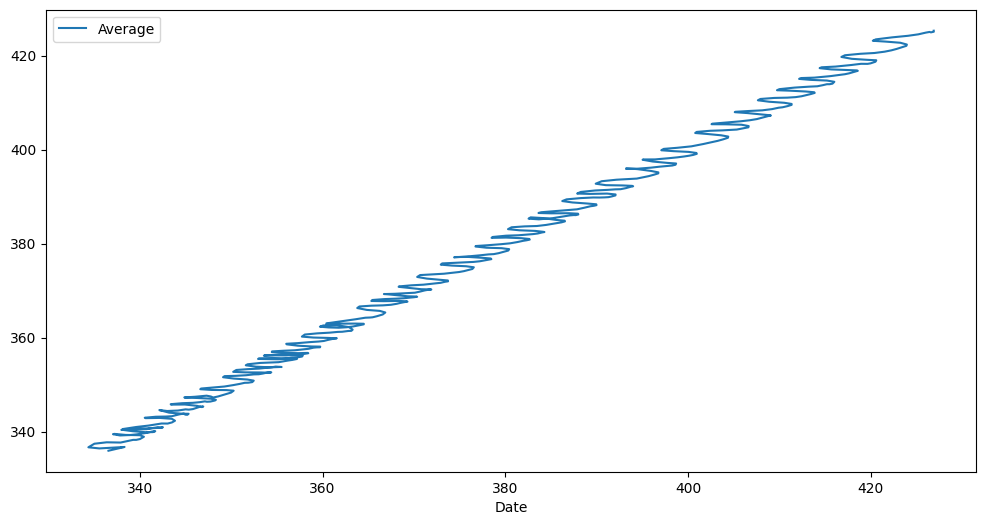

In [4]:
# Section 4.3

# Plotting the CO2 trend
data[["Average"]].plot(figsize=(12,6))

## Creating the `Average Diff` column

`Average Diff` is computed as,

`Average Diff(t) = Average(t) - Average(t-1)`

In [5]:
# Section 4.3

data["Average Diff"] = data["Average"] - data["Average"].shift(1).fillna(method='bfill')
data.head()

/tmp/ipython-input-1966996508.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data["Average Diff"] = data["Average"] - data["Average"].shift(1).fillna(method='bfill')


,Decimal Date,Average,Trend,Average Diff
Date,,,,
336.56,0.11,335.92,0.10,0.00
337.29,0.09,336.25,0.10,0.33
337.88,0.11,336.51,0.10,0.26
338.32,0.13,336.72,0.11,0.21
338.26,0.04,336.71,0.11,-0.01


<Axes: xlabel='Date'>

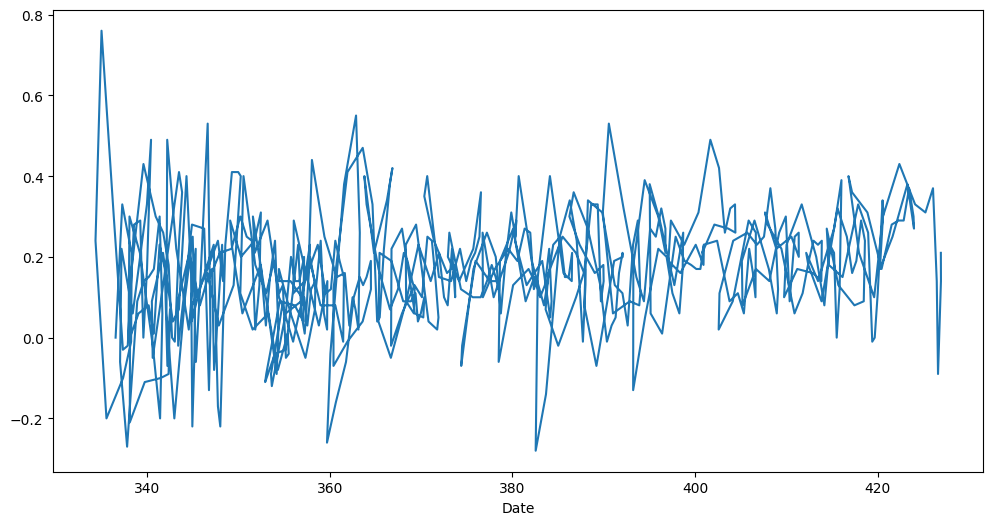

In [6]:
# Section 4.3

data["Average Diff"].plot(figsize=(12,6))

## Generating time-series data for the model

In [7]:
# Section 4.3
# Code listing 4.4/Code listing 4.5

import numpy as np

def generate_data(co2_arr,n_seq):
    """ Generating data for the model.
    Input is a matrix of size (n x n_seq) and
    Output is a vector of size n. """

    x, y = [],[]
    for i in range(co2_arr.shape[0]-n_seq):
        x.append(co2_arr[i:i+n_seq-1])
        y.append(co2_arr[i+n_seq-1:i+n_seq])
    x = np.array(x).reshape(-1,n_seq-1,1)
    y = np.array(y)
    return x,y

# Generating the data
x, y = generate_data(data["Average Diff"].values, 13)

# Let's print some data and see what we got
print("Original values: ", data["Average Diff"].values[:20])
print()
i = 0
for xx, yy in zip(x,y):
    print('x: ',xx.ravel(), ' y: ', yy.ravel())
    i += 1
    if i>5: break

Original values:  [ 0.    0.33  0.26  0.21 -0.01 -0.1  -0.2   0.24  0.76  0.3  -0.03 -0.02
  0.28  0.29  0.    0.17  0.49  0.33  0.06  0.22]

x:  [ 0.    0.33  0.26  0.21 -0.01 -0.1  -0.2   0.24  0.76  0.3  -0.03 -0.02]  y:  [0.28]
x:  [ 0.33  0.26  0.21 -0.01 -0.1  -0.2   0.24  0.76  0.3  -0.03 -0.02  0.28]  y:  [0.29]
x:  [ 0.26  0.21 -0.01 -0.1  -0.2   0.24  0.76  0.3  -0.03 -0.02  0.28  0.29]  y:  [0.]
x:  [ 0.21 -0.01 -0.1  -0.2   0.24  0.76  0.3  -0.03 -0.02  0.28  0.29  0.  ]  y:  [0.17]
x:  [-0.01 -0.1  -0.2   0.24  0.76  0.3  -0.03 -0.02  0.28  0.29  0.    0.17]  y:  [0.49]
x:  [-0.1  -0.2   0.24  0.76  0.3  -0.03 -0.02  0.28  0.29  0.    0.17  0.49]  y:  [0.33]


## Defining and training the model

In [8]:
# Section 4.3

from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

K.clear_session()

# Defining the model
rnn = models.Sequential([
    layers.SimpleRNN(64),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
# Compiling the model
rnn.compile(loss='mse', optimizer='adam')

In [9]:
# Section 4.3
rnn.fit(x, y, shuffle=True, batch_size=64, epochs=25)

Epoch 1/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0172
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0140
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0130
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0121
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0112
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0106
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0103
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0100
Epoch 9/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0098 
Epoch 10/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096 
Epoch 11/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096 
Epoch 12/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0095 
Epoch 13/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0094 
Epoch 14/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0092 
Epoch 15/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0091 
Epoch 16/25
9/9 ━━━━━━━━━━━━━━━━━━

## Predicting using the trained model

In [10]:
# Section 4.3
# Code listing 4.6

import numpy as np

# Getting the last 12 values from the history to generate the first prediction
history = data["Average Diff"].values[-12:].reshape(1,-1,1)

# To hold the absolute values
true_vals = []

# Holds the very last value in the history
prev_true = data["Average"].values[-1]

# Making predictions for 60 time steps
for i in range(60):
    # Make a single prediction
    p_diff = rnn.predict(history).reshape(1,-1,1)

    # Modifying the history so that we have
    history = np.concatenate((history[:,1:,:],p_diff),axis=1)
    # Generating the absolute prediction
    true_vals.append(prev_true+p_diff[0,0,0])
    # Updating the prev_true
    prev_true = true_vals[-1]

print("Predictions: {}".format(true_vals[:10]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

## Plotting the current values and predictions

ValueError: time data "426" doesn't match format "%Y-%m-%d", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

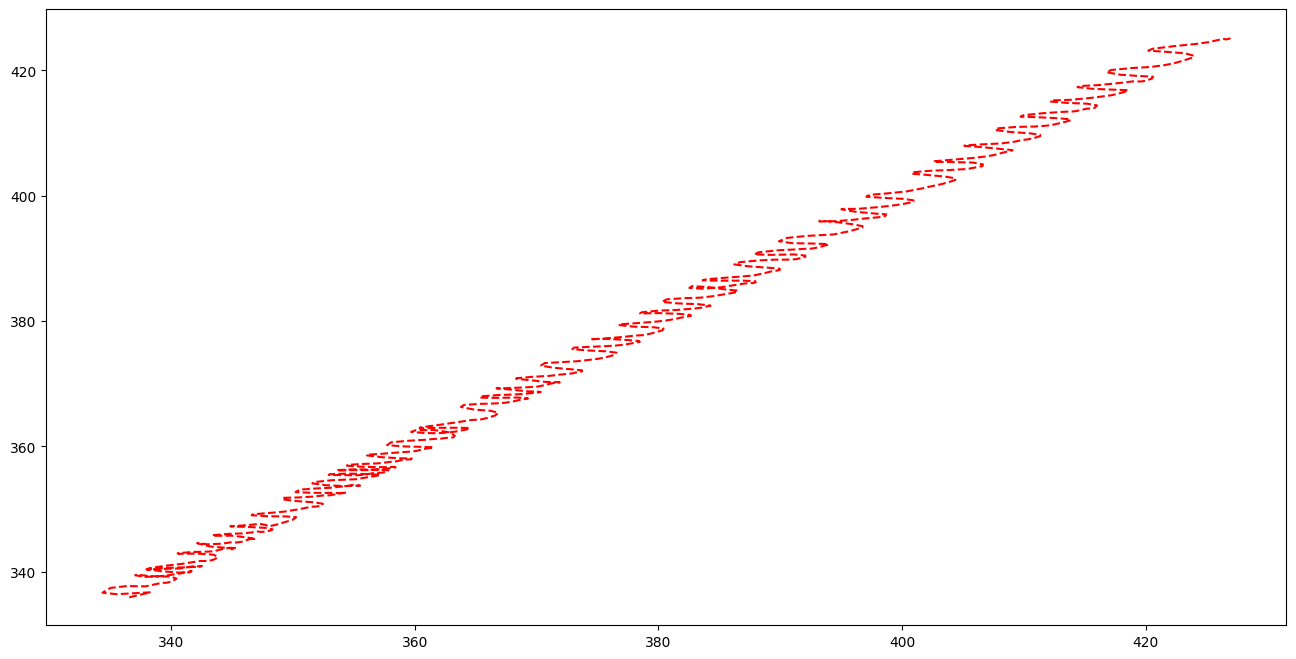

In [11]:
# Section 4.3

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Plotting the current and predicted trends
plt.figure(figsize=(16,8))

# Plotting the current trend
plt.plot(data["Average"], c='r', linestyle='--', label="Current trend")

# Creating a pd.Series from predictions
pred_ser = pd.Series(
    [data["Average"].values[-1]]+true_vals,
    index=[data.index[-1]]+[pd.to_datetime(data.index[-1], format="%Y-%m-%d")+pd.DateOffset(months=i+1) for i in range(60)]
)
pred_ser.index = pd.to_datetime(pred_ser.index).strftime('%Y-%m-%d')

# Plotting the predictions
plt.plot(pred_ser, c='g', label='Predicted trend')

# Annotating the plot
plt.xticks(np.arange(0, data["Average"].shape[0]+60, 24),rotation=45)
plt.xlabel('Time', fontsize=18)
plt.ylabel('CO2 Concentration', fontsize=18)
plt.legend(prop={'size': 15})
plt.title('Evolution of CO2 Concentration over Time', fontsize=18)